# U-Net BUSI Segmentation — Project Summary Notebook


This notebook summarizes the full segmentation project on the BUSI dataset.
It includes:
- Dataset overview
- Model architecture summary
- Training results (loss, accuracy, Dice)
- Visual predictions from the test set


# Dataset Overview

The dataset used in this project is the **BUSI dataset** (Breast Ultrasound Images), which contains ultrasound images of breast tissue. Each image is associated with a corresponding segmentation mask indicating the region of a tumor (if present).

- **Format**: grayscale `.png` images and binary masks
- **Source**: publicly available medical imaging dataset for breast lesion detection (Kaggle Dataset : Dataset_BUSI_with_GT)
- **Classes**: binary (tumor vs. background)


In its original form, the dataset consisted of three folders : benign, malignant and normal to divide the different cases.

To prepare the dataset for training, we applied the following preprocessing steps:

We created 2 folders : 
- `data/images/` containing all the input ultrasound images
- `data/masks/` containing all the corresponding segmentation masks with the same filenames

Each mask has the same filename as the image it corresponds to, enabling one-to-one matching. Then, we split randomly the dataset using the following proportions:
   - 70% for training
   - 15% for validation
   - 15% for testing  
   The files were copied into the following structure:
   `data/ 
      ├── train/ │ 
         ├── images/ │ └── masks/ 
      ├── val/ │ 
         ├── images/ │ └── masks/ 
      └── test/ │
         ├── images/ │└── masks/`

This allowed each subset to be loaded easily using PyTorch `Dataset` and `DataLoader` classes. All images and masks were resized to a fixed size of 256x256 pixels before being passed into the model.




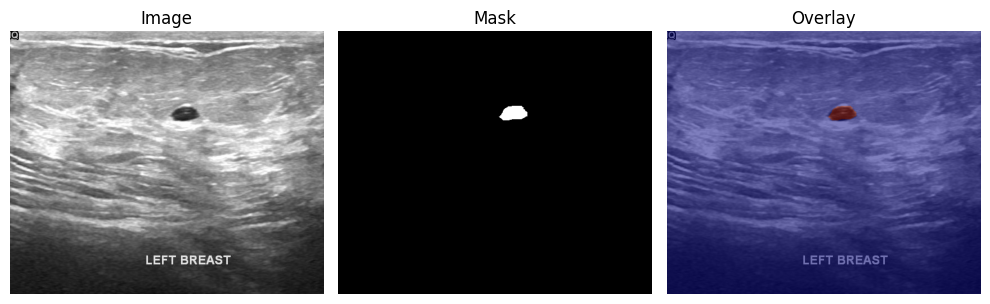

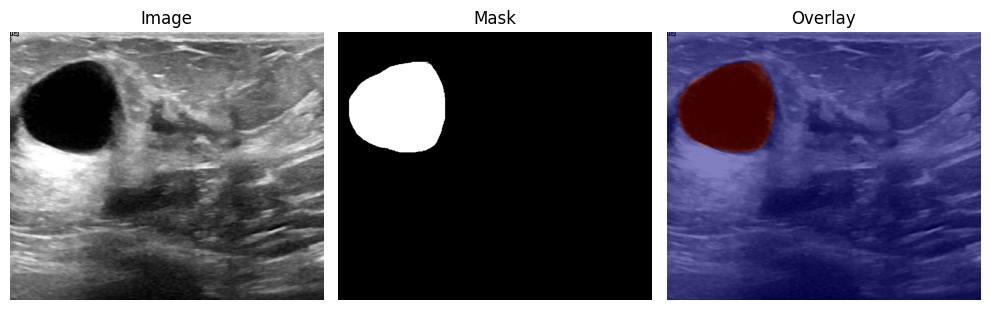

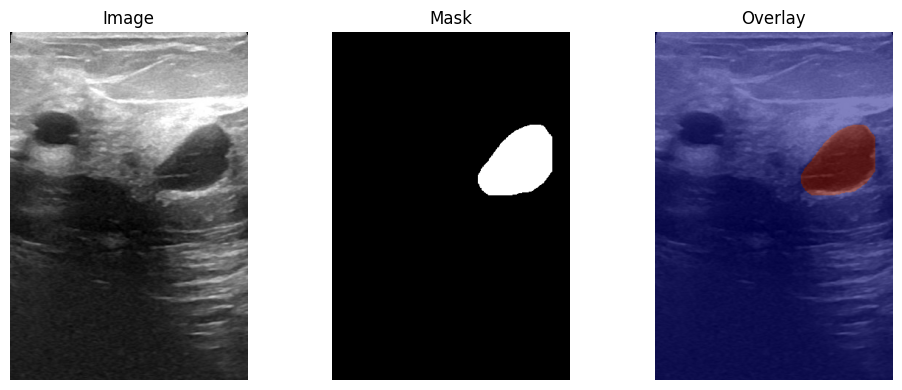

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

project_root = Path().resolve().parent  
image_dir = project_root / "data" / "images"
mask_dir = project_root / "data" / "masks"

image_files = sorted(image_dir.glob("*.png"))[:3]

for img_path in image_files:
    filename = img_path.name
    mask_path = mask_dir / filename

    image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(image, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.5)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Model Architecture Summary

# Training Results

In [2]:
import os
import sys

# ➤ Ajoute le chemin du dossier parent pour trouver le module 'src'
sys.path.append(os.path.abspath(".."))

# ➤ Ensuite, tu peux importer
from src.unet import UNet
from src.dataset import BUSIDataset
from src.utils import compute_dice, compute_accuracy


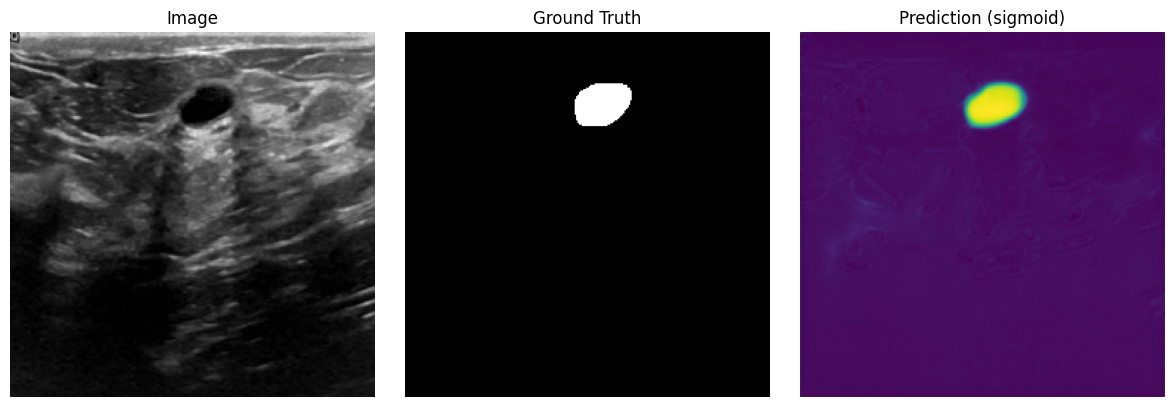

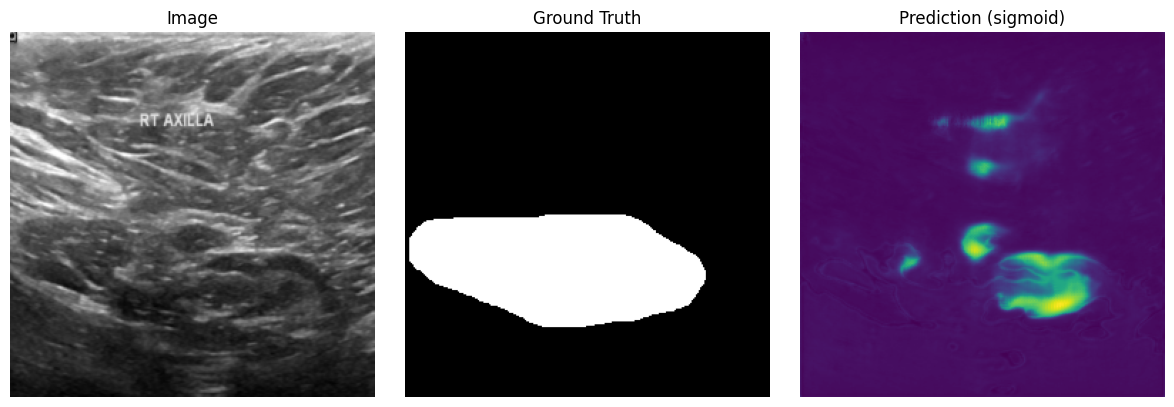

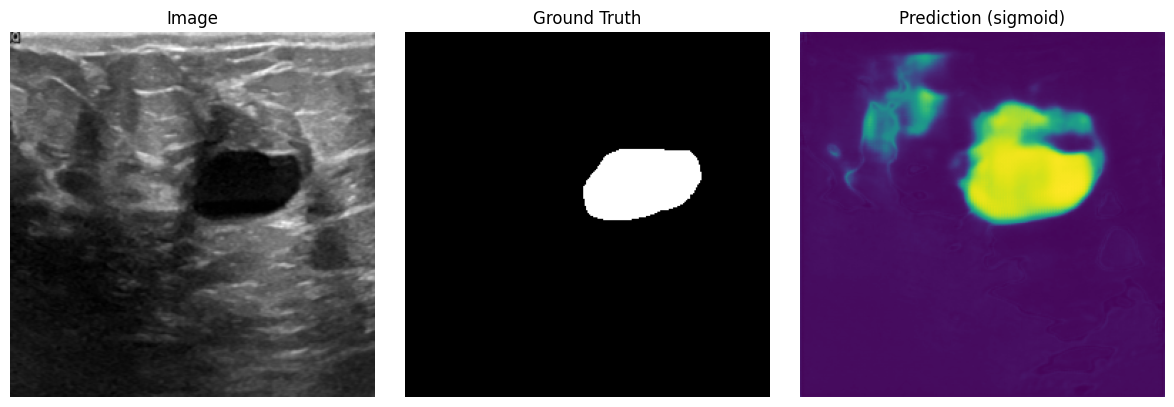

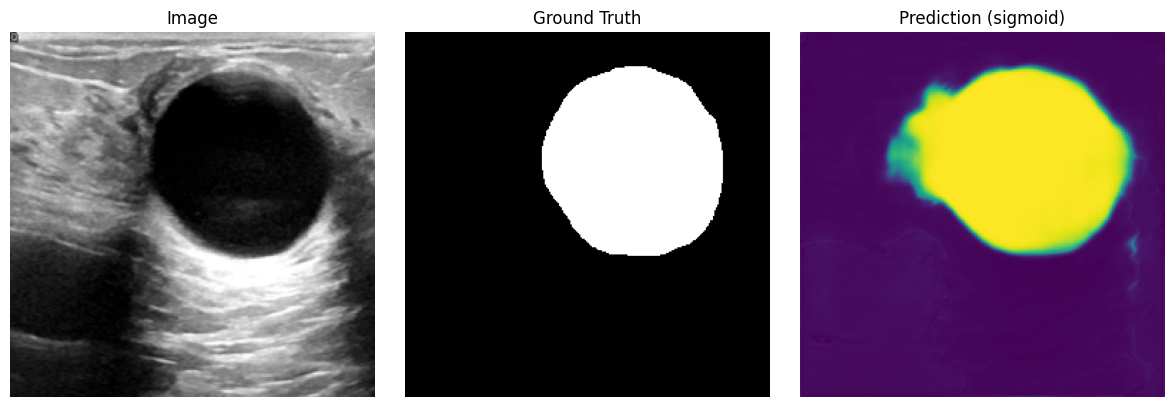

Test Dice Score: 0.6082
Test Accuracy:   0.9340


([0.9320987462997437,
  0.1781666874885559,
  0.679966926574707,
  0.9030476808547974,
  1.5401201364576012e-12,
  0.8433734774589539,
  0.9027794599533081,
  0.544753909111023,
  0.2874327301979065,
  0.6995290517807007,
  0.8213512897491455,
  0.9078432321548462,
  0.2605992555618286,
  0.5365303158760071,
  1.958863843701253e-12,
  0.735334038734436,
  8.019246074478237e-13,
  0.8921109437942505,
  0.6483439207077026,
  0.7930051684379578,
  0.8491314649581909,
  0.8721234798431396,
  0.6018348336219788,
  0.6150144338607788,
  0.9022937417030334,
  0.8032840490341187,
  0.8506089448928833,
  0.48641520738601685,
  0.7646390199661255,
  0.004211332183331251,
  0.3008898198604584,
  0.8916990756988525,
  0.9293799996376038,
  0.9026976227760315,
  0.41649964451789856,
  0.8818380832672119,
  0.765296220779419,
  0.5289957523345947,
  0.32261162996292114,
  0.22940562665462494,
  1.914975122918605e-12,
  0.3636363744735718,
  0.11789889633655548,
  0.8314606547355652,
  0.553115725517

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import sys


# ----------- Config ---------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(DEVICE)
model.load_state_dict(torch.load("/Users/clarachoukroun/unet-busi-project/results/unet_final.pt", map_location=DEVICE))
model.eval()

# ----------- Evaluation ----------
def evaluate_model(model, device, image_dir, mask_dir, size=(256, 256), batch_size=1, n_visuals=4):
    model.eval()
    dataset = BUSIDataset(image_dir, mask_dir, size=size)
    loader = DataLoader(dataset, batch_size=batch_size)
    
    dice_scores = []
    acc_scores = []
    shown = 0

    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(device), mask.to(device)
            pred = torch.sigmoid(model(img))

            dice = compute_dice(pred, mask)
            acc = compute_accuracy(pred, mask)
            dice_scores.append(dice.item())
            acc_scores.append(acc.item())

            if shown < n_visuals:
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img[0].cpu().squeeze(), cmap="gray")
                axs[0].set_title("Image")
                axs[1].imshow(mask[0].cpu().squeeze(), cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[2].imshow(pred[0].cpu().squeeze(), cmap="viridis")
                axs[2].set_title("Prediction (sigmoid)")
                for ax in axs:
                    ax.axis("off")
                plt.tight_layout()
                plt.show()
                shown += 1

    print(f"Test Dice Score: {np.mean(dice_scores):.4f}")
    print(f"Test Accuracy:   {np.mean(acc_scores):.4f}")

    return dice_scores, acc_scores

evaluate_model(model, DEVICE, "/Users/clarachoukroun/unet-busi-project/data/test/images", "/Users/clarachoukroun/unet-busi-project/data/test/masks")



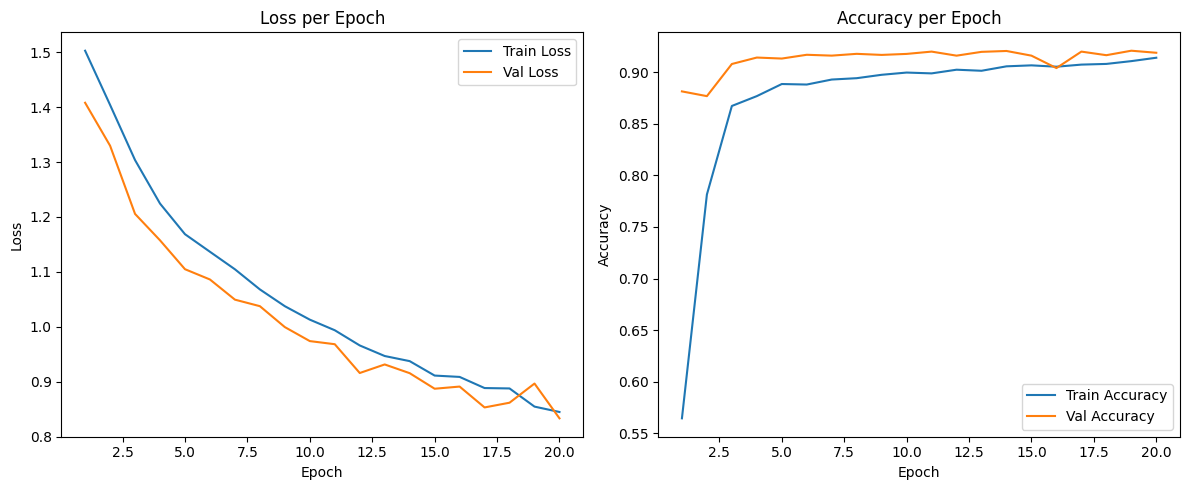

In [7]:
import matplotlib.pyplot as plt

def plot_training_logs(train_logs, val_logs):
    epochs = range(1, len(train_logs["loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # 📉 Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_logs["loss"], label="Train Loss")
    plt.plot(epochs, val_logs["loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()

    # 📈 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_logs["acc"], label="Train Accuracy")
    plt.plot(epochs, val_logs["acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()


train_losses = np.load("/Users/clarachoukroun/unet-busi-project/results/train_losses.npy")
train_accs = np.load("/Users/clarachoukroun/unet-busi-project/results/train_accs.npy")
val_losses = np.load("/Users/clarachoukroun/unet-busi-project/results/val_losses.npy")
val_accs = np.load("/Users/clarachoukroun/unet-busi-project/results/val_accs.npy")
plot_training_logs(
    train_logs={"loss": train_losses, "acc": train_accs},
    val_logs={"loss": val_losses, "acc": val_accs}
)



In [ ]:
def show_overlay(image, mask, prediction):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap="gray")
    plt.imshow(prediction, alpha=0.5, cmap="Reds")
    plt.title("Overlay Prediction")
    plt.tight_layout()
    plt.show()

show_overlay()